In [1]:
import pandas as pd
import os.path
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg

class StopCell(Exception): # a custom (mute) exception to exit cells programmatically ("raise StopCell")
    def _render_traceback_(self):
        pass

# Analysis Tactile Revcor
&copy; Céline Vanney, Etienne Louyot, JJ Aucouturier, PH Cornuault, Luc Carpentier


## Behavioural data

### Load & prepare data

In [2]:
for file in glob.glob("./data/*results*.csv"):
    print(file)

#### Fix condition field & filename

Result files from participant 7 onwards include a `condition` field, and have their condition in the filename. Correct this for earlier participants. 

In [3]:
if True: raise StopCell

conditions = {'1':'rug', '2':'soft', '3':'soft',
             '4':'soft', '5':'soft','6':'soft'}

for participant in np.arange(1,7): 
    
    # get participant file
    file = glob.glob("./data/*results_subj%d*.csv"%participant)[0]
    
    # add condition in pandas
    condition = conditions[str(participant)]
    participant_data = pd.read_csv(file)
    participant_data['condition'] = condition
    
    # and save as new csv file with updated filename
    name, ext = os.path.splitext(os.path.basename(file))
    updated_filename = './data/' + name + '_'+ condition + ext
    participant_data.to_csv(updated_filename,index=False)

#### Load all data

In [4]:
data_dir = 'data'
data_files = glob.glob("./data/*results*.csv")
print("got %d behavioural files, "%len(data_files), end='')
data = pd.DataFrame()
for data_file in data_files:
    participant_data = pd.read_csv(data_file, sep = ',', decimal='.', header='infer')
    data = data.append(participant_data, ignore_index=True)
print('%d subjects'%data.subj.nunique())

got 27 behavioural files, 27 subjects


In [22]:
data.groupby(['condition','sex']).subj.nunique()

condition  sex
rug        f       3
           m       4
soft       f      12
           m       8
Name: subj, dtype: int64

#### Remove skipped blocks

<AxesSubplot:xlabel='subj', ylabel='trial'>

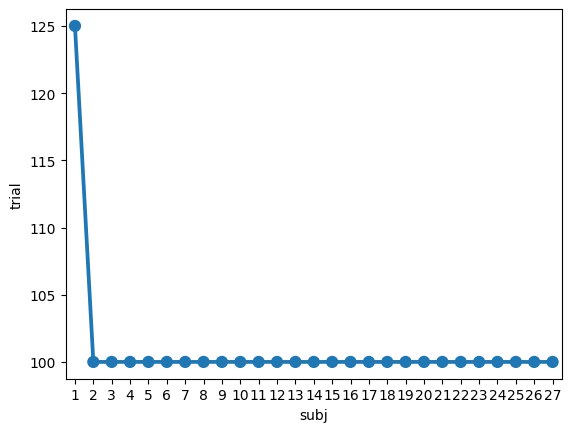

In [6]:
# all subjects have 100 trials, except subj1
d=data[data.practice==False].groupby(['subj']).agg({'trial':'count'})/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

subj1 had 5 blocks of 25, and the last block was skipped by the experimenter (rt=0s); subj1 is the only subj with 5 blocks: remove block 5 from data

In [7]:
data[data.subj==1].groupby(['block']).rt.mean()

block
0    0.41900
1    7.37944
2    8.14860
3    7.22304
4    7.62980
5    0.00004
Name: rt, dtype: float64

In [8]:
data.groupby('block').subj.unique()

block
0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
3    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
4    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5                                                  [1]
Name: subj, dtype: object

In [9]:
data = data[data.block.isin([1,2,3,4])]

#### Number of different textures

Participants 1-6 were presented trials sampled from a reduced set of textures; participants >6 used the complete set. 

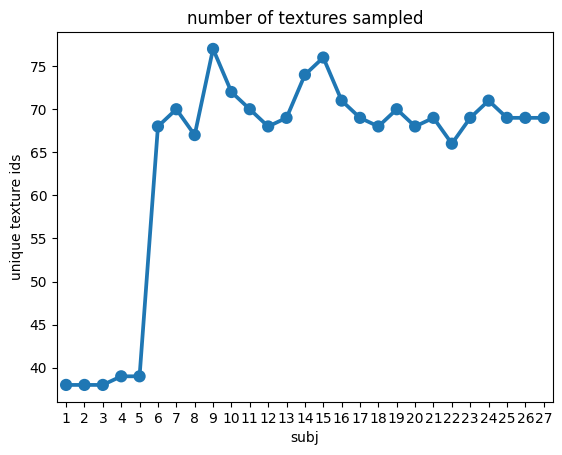

In [10]:
sns.pointplot(data=data.groupby('subj', as_index=False).texture_id.nunique(),
              x='subj',y='texture_id')
plt.title('number of textures sampled')
_=plt.ylabel('unique texture ids')

## Kernel

### Kernel computation

In [11]:
data_melt = pd.melt(data,
        id_vars=['subj','trial','block','sex','age','condition','response'],
        value_vars=['diameter','opening','spacing'],
        var_name='feature')

# z-score feature values
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
# zscore TAS and weights
data_melt['value'] = data_melt.groupby(['subj','feature'])['value'].transform(zscore) 

# compute difference between positives and negatives in each trial
positives = data_melt.loc[data_melt.response == True].reset_index()
negatives = data_melt.loc[data_melt.response == False].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','block','trial','feature'],suffixes=['+','-'])
kernels['delta_value']=kernels['value+']-kernels['value-']

kernels.drop(['index+','response+', 'value+', 
               'index-', 'sex-', 'age-', 'condition-', 'response-', 'value-'], axis=1, inplace=True)
kernels = kernels.rename(columns={'sex+':'sex','age+':'age', 'condition+':'condition'})

# normalize for each subj by dividing by the RMS of their values over all trials 
kernels['square_delta_value'] = kernels['delta_value']**2

for_norm = kernels.groupby(['subj','condition','feature']).agg({'square_delta_value':'mean'}).reset_index()
                                          
kernels = pd.merge(kernels, for_norm, on=['subj','condition','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])

kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)


### Different kernels per condition

In [14]:
kernels.groupby(['condition','feature']).norm_delta_value.mean()

condition  feature 
rug        diameter   -0.006298
           opening     0.613785
           spacing     0.294076
soft       diameter   -0.121706
           opening    -0.510029
           spacing    -0.342440
Name: norm_delta_value, dtype: float64

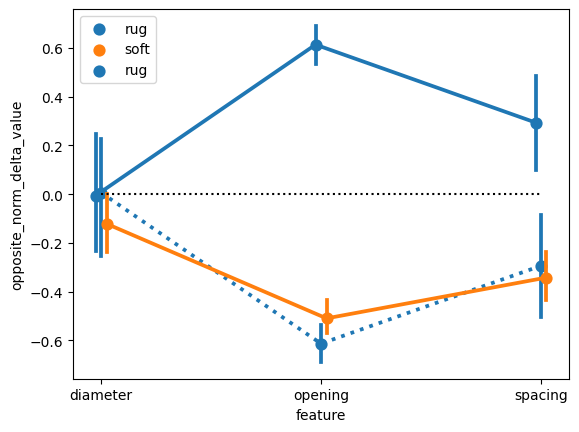

In [21]:
sns.pointplot(data=kernels,
              hue="condition",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

# plot inverse rough kernel for comparison
kernels['opposite_norm_delta_value'] = - kernels.norm_delta_value
sns.pointplot(data=kernels[kernels.condition=='rug'],
              hue="condition",
             x="feature",
              units='subj',
             y="opposite_norm_delta_value", 
              linestyles=[':'])

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

One-sample difference of kernel weights to zero

In [13]:
print("One-sample difference of kernel weights to zero")
for condition in ['rug','soft']:
    print('%s:'%condition.upper())
    for feature in ['diameter','opening','spacing']: 
        
        print('- %s'%(feature))
        
        sample = kernels[(kernels.condition==condition)&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
        
        stats= pg.ttest(x=sample.norm_delta_value, y=0)
        print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

One-sample difference of kernel weights to zero
RUG:
- diameter
t(6)=-0.05,p=0.9618
- opening
t(6)=20.43,p=0.0000
- spacing
t(6)=2.70,p=0.0358
SOFT:
- diameter
t(19)=-1.97,p=0.0632
- opening
t(19)=-17.80,p=0.0000
- spacing
t(19)=-6.72,p=0.0000


Two-sample difference of kernel weights between soft and non-rough

In [15]:
print("Two-sample difference of kernel weights between soft and non-rough")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_soft = kernels[(kernels.condition=='soft')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_rug = kernels[(kernels.condition=='rug')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_soft.norm_delta_value, 
                    y=-sample_rug.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between soft and non-rough
- diameter
t(9)=-0.91,p=0.3853
- opening
t(17)=2.50,p=0.0228
- spacing
t(8)=-0.40,p=0.6976


### Sex difference for soft

In [16]:
data.groupby(['condition','sex']).subj.nunique()

condition  sex
rug        f       3
           m       4
soft       f      12
           m       8
Name: subj, dtype: int64

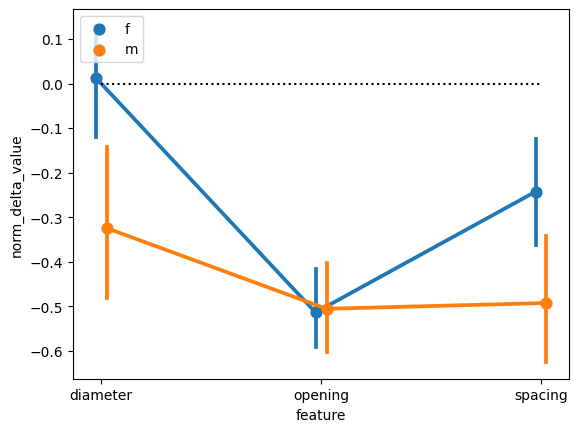

In [19]:
sns.pointplot(data=kernels[kernels.condition=='soft'],
              hue="sex",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

In [20]:
print("Two-sample difference of kernel weights between male and female soft")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_male = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='m')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_female = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='f')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_male.norm_delta_value, 
                    y=sample_female.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between male and female soft
- diameter
t(13)=-3.17,p=0.0073
- opening
t(15)=0.14,p=0.8934
- spacing
t(14)=-2.77,p=0.0145


Remember that the first few participants (3 ?) had a bug that resulted in not stopping the recording at the time of response

(-0.01, 0.05)

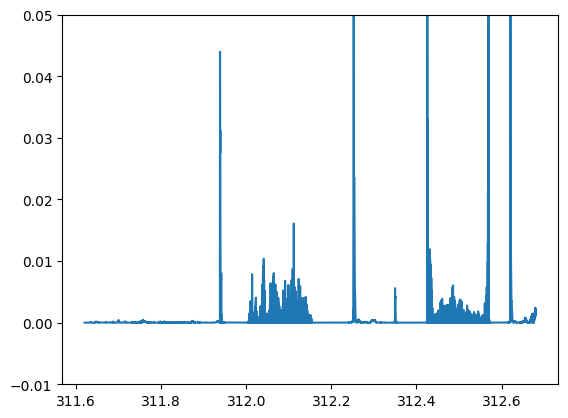